# Reimplementation of _Topic Modeling with Wasserstein Autoencoders_ by Feng Nan et al. (2019)

#### Group Members: Aryaan Khan, Yuhang Cui, and Raymond Lee

### Import Libraries

In [56]:
import re
import nltk
import torch
import pprint
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from nltk.stem import WordNetLemmatizer
from torch.distributions import Dirichlet
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Define the device
device = torch.device("cpu")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aryaankhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aryaankhan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load the Dataset

In [38]:
# Load the 20 Newsgroups dataset
categories = None
data = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))

# Accessing the text data
texts = data.data

### Preprocess the Data

In [52]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    
    # Tokenization
    tokens = text.split()
    
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Re-create document from tokens
    return ' '.join(tokens)

In [53]:
# Apply preprocessing to each document in the dataset
processed_texts = [preprocess_text(text) for text in texts]

# Example of a processed text
print(processed_texts[1])

In [42]:
# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(processed_texts)

# Review the shape of the TF-IDF matrix
print(tfidf_matrix.shape)


(18846, 1000)


### Define an Encoder and Decoder

In [6]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_topics):
        super(Encoder, self).__init__()
        # MLP with one hidden layer
        self.fc1 = nn.Linear(vocab_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_topics)
    
    def forward(self, w):
        # Apply softmax to output layer to get topic distribution theta
        theta = F.softmax(self.fc2(F.relu(self.fc1(w))), dim=1)
        return theta


class Decoder(nn.Module):
    def __init__(self, num_topics, vocab_size):
        super(Decoder, self).__init__()
        # Beta is the matrix of topic-word vectors (num_topics x vocab_size)
        self.beta = nn.Parameter(torch.randn(num_topics, vocab_size))
        # Bias term
        self.bias = nn.Parameter(torch.randn(vocab_size))
    
    def forward(self, theta):
        # Reconstruction of bag-of-words representation
        logit = F.softmax(torch.matmul(theta, self.beta) + self.bias, dim=1)
        return logit


### Define the Wasserstein Autoencoder Model

In [7]:
class WAE(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_topics):
        super(WAE, self).__init__()
        self.encoder = Encoder(vocab_size, hidden_dim, num_topics)
        self.decoder = Decoder(num_topics, vocab_size)

    def forward(self, w):
        theta = self.encoder(w)
        recon = self.decoder(theta)
        return recon, theta

def loss_function(w, recon_w):
    # Negative cross-entropy loss
    return -torch.sum(w * torch.log1p(recon_w + 1e-10), dim=1).mean()

### Train the WAE Model

In [21]:
# Function to compute MMD loss
def compute_mmd_loss(theta, prior, kernel):
    n_samples = theta.size(0)
    true_samples = prior.sample((n_samples,))
    
    xx = kernel(theta, theta).mean()
    yy = kernel(true_samples, true_samples).mean()
    zz = kernel(theta, true_samples).mean()
    
    return xx + yy - 2 * zz

# Kernel function for MMD
def mmd_kernel(theta, theta_prime, eps=1e-7):
    # Ensure the inputs are on the correct device (theta is assumed to be on the correct device)
    theta_prime = theta_prime.to(theta.device)
    
    # Compute the cosine similarity and ensure it is in the range [-1, 1] for numerical stability
    cosine_similarity = torch.sum(torch.sqrt(theta + eps) * torch.sqrt(theta_prime + eps), dim=1)
    cosine_similarity = torch.clamp(cosine_similarity, -1 + eps, 1 - eps)
    
    # Compute the kernel function
    kernel_value = torch.exp(-torch.arccos(cosine_similarity) ** 2)
    
    return kernel_value


# Function to add noise to the encoder output
def add_noise_to_theta(theta, alpha, concentration):
    noise = Dirichlet(concentration).sample((theta.size(0),)).to(device)
    return (1 - alpha) * theta + alpha * noise

# Modify the training loop to include MMD loss and noise
def train(model, data_loader, optimizer, alpha, concentration, epochs=5):
    model.train()
    prior = Dirichlet(concentration)
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data,) in enumerate(data_loader):
            optimizer.zero_grad()
            theta = model.encoder(data)
            theta_noise = add_noise_to_theta(theta, alpha, concentration)
            recon = model.decoder(theta_noise)
            
            recon_loss = loss_function(data, recon)
            mmd_loss = compute_mmd_loss(theta, prior, mmd_kernel)
            loss = recon_loss + mmd_loss  # Combine the reconstruction and MMD losses
            
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        avg_loss = total_loss / len(data_loader.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}')

In [35]:
# Normalize the TF-IDF matrix
normalized_tfidf_matrix = normalize(tfidf_matrix)

# Convert the normalized TF-IDF matrix to a dense PyTorch tensor
tfidf_tensor = torch.from_numpy(normalized_tfidf_matrix.toarray()).float().to(device)  # Send to device

# Create a dataset and dataloader
dataset = TensorDataset(tfidf_tensor)  # tfidf_tensor is already on the device
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the WAE model and send it to the device
vocab_size = tfidf_tensor.shape[1]  # Number of features in the TF-IDF representation
hidden_dim = 100  # Example value, you may want to tune this
num_topics = 5  # Assuming we want to discover 20 topics
wae = WAE(vocab_size, hidden_dim, num_topics).to(device)  # Send to device

# Choose an optimizer
optimizer = torch.optim.Adam(wae.parameters(), betas=(0.99, 0.999), lr=0.002)

# Example alpha and Dirichlet concentration parameter for noise, send to device
alpha = 0.1
concentration = torch.ones(num_topics, device=device)  # Send to device

# Assuming that the train function correctly handles the device,
# you can now call the train function with the new parameters:
train(wae, data_loader, optimizer, alpha, concentration, epochs=10)

# Save the model if needed
# Note: When loading the model state, you'll need to map the location to the device
torch.save(wae.state_dict(), 'wasserstein_ae.pth')

Epoch 1/10, Average Loss: 0.010199465805603974
Epoch 2/10, Average Loss: 0.009958612593726015
Epoch 3/10, Average Loss: 0.00965628074487025
Epoch 4/10, Average Loss: 0.009571513588623574
Epoch 5/10, Average Loss: 0.009602773973741412
Epoch 6/10, Average Loss: 0.009606294284121924
Epoch 7/10, Average Loss: 0.009496557004737914
Epoch 8/10, Average Loss: 0.009501730700397167
Epoch 9/10, Average Loss: 0.009560539409997394
Epoch 10/10, Average Loss: 0.009430427913495996


### Evaluate the Model

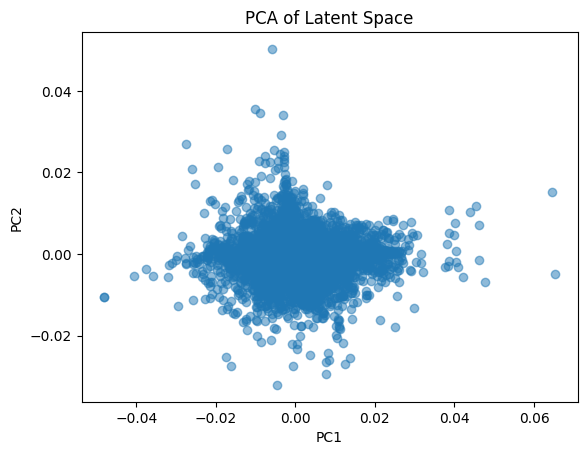

In [27]:
wae.load_state_dict(torch.load('wasserstein_ae.pth'))

# Assuming 'model' is already trained and 'tfidf_matrix' is available
wae.eval()

# Extract the latent representations
latent_variables = []
for i in range(tfidf_matrix.shape[0]):
    data_point = torch.tensor(tfidf_matrix[i].toarray()).float().to(device)
    _, z = wae(data_point)
    latent_variables.append(z.detach().cpu().numpy())

latent_variables = np.array(latent_variables).squeeze()

# Use PCA for dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_latent = pca.fit_transform(latent_variables)

# Plot
plt.scatter(reduced_latent[:, 0], reduced_latent[:, 1], alpha=0.5)
plt.title('PCA of Latent Space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

18846


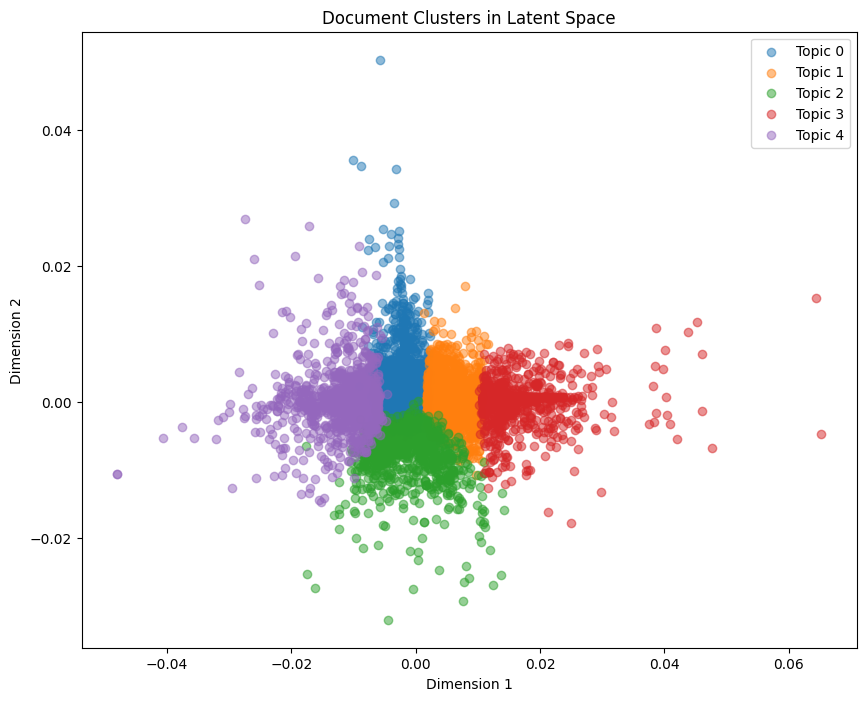

In [28]:
kmeans = KMeans(n_clusters=num_topics, random_state=0).fit(latent_variables)
labels = kmeans.labels_

plt.figure(figsize=(10, 8))
for i in range(num_topics):
    plt.scatter(reduced_latent[labels == i, 0], reduced_latent[labels == i, 1], label=f'Topic {i}', alpha=0.5)
plt.title('Document Clusters in Latent Space')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [55]:
# Cluster the latent space to identify topics
num_topics = 5
kmeans = KMeans(n_clusters=num_topics, random_state=0).fit(latent_variables)
labels = kmeans.labels_

words = vectorizer.get_feature_names_out()  # For sklearn versions 0.24 and later use get_feature_names_out()

top_words_per_topic = []
for i in range(num_topics):  # 'num_topics' is the number of clusters you decided in KMeans
    # Calculate mean TF-IDF score for words in documents of each cluster
    topic_mean = np.array(tfidf_matrix[labels == i].mean(axis=0)).flatten()
    
    # Get indices of top 10 words for this topic
    top_indices = topic_mean.argsort()[-30:][::-1]  # Change 10 to another number if you want more or fewer words
    top_features = [words[index] for index in top_indices]
    top_words_per_topic.append(top_features)

# Example output
print("Top words per topic:")
for i, words in enumerate(top_words_per_topic):
    print(f"Topic {i}: {words}")


Top words per topic:
Topic 0: ['would', 'get', 'know', 'like', 'dont', 'one', 'im', 'think', 'anyone', 'thanks', 'time', 'window', 'could', 'problem', 'people', 'also', 'use', 'good', 'much', 'please', 'work', 'say', 'file', 'well', 'new', 'make', 'drive', 'need', 'year', 'thing']
Topic 1: ['one', 'people', 'year', 'would', 'dont', 'know', 'like', 'think', 'right', 'make', 'good', 'get', 'god', 'time', 'well', 'may', 'number', 'also', 'im', 'game', 'even', 'say', 'way', 'two', 'could', 'thing', 'many', 'said', 'team', 'new']
Topic 2: ['use', 'would', 'please', 'server', 'system', 'know', 'question', 'thanks', 'email', 'mr', 'drive', 'get', 'problem', 'card', 'one', 'also', 'port', 'dont', 'anyone', 'display', 'post', 'monitor', 'like', 'case', 'bit', 'could', 'must', 'file', 'using', 'right']
Topic 3: ['one', 'church', 'christian', 'number', 'right', 'people', 'good', 'god', 'way', 'two', 'law', 'know', 'year', 'little', 'would', 'think', 'new', 'gun', 'child', 'well', 'im', 'may', 'po

In [58]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

# Assuming 'wae' is your trained model and 'vectorizer' is your TfidfVectorizer

# First, get the beta matrix from the decoder (topic-word distribution)
beta = wae.decoder.beta.cpu().detach().numpy()

# Extract the top words for each topic
top_n = 30  # Number of top terms to extract for each topic
top_words = np.array(vectorizer.get_feature_names_out())
top_words_topic = np.argsort(beta, axis=1)[:, -top_n:][::-1]
topics = [top_words[topic_idxs] for topic_idxs in top_words_topic]

# Convert the tokenized documents to a Gensim dictionary
tokenized_docs = [doc.split() for doc in processed_texts]
gensim_dictionary = Dictionary(tokenized_docs)

# Convert tokenized documents into a document-term matrix for Gensim
corpus = [gensim_dictionary.doc2bow(doc) for doc in tokenized_docs]

# Compute Coherence Score using Gensim's CoherenceModel
coherence_model = CoherenceModel(topics=topics, texts=tokenized_docs, dictionary=gensim_dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

print(f'Coherence Score: {coherence_score}')

Coherence Score: 0.35059177307899725


In [32]:
from collections import Counter

def topic_uniqueness_score(top_words_per_topic):
    # Flatten the list of top_words_per_topic
    all_words = [word for topic in top_words_per_topic for word in topic]
    word_counts = Counter(all_words)
    
    # Calculate the uniqueness score
    uniqueness_scores = dict()
    for i in range(len(top_words_per_topic)):
        uniqueness_scores[i] = sum([1 / word_counts[word] for word in top_words_per_topic[i]])/len(top_words_per_topic[i])
    return uniqueness_scores

In [33]:
# Cluster the latent space to identify topics
print(topic_uniqueness_score(top_words_per_topic))

{0: 0.3843333333333333, 1: 0.3643333333333333, 2: 0.5601666666666668, 3: 0.4460000000000002, 4: 0.4351666666666667}


In [59]:
# print(top_words, top_words_topic, topics)
pprint.pp(topics)

[array(['board', 'still', 'thing', 'method', 'two', 'im', 'type', 'want',
       'rule', 'work', 'last', 'go', 'program', 'currently', 'people',
       'good', 'used', 'light', 'take', 'also', 'use', 'think', 'year',
       'problem', 'get', 'know', 'dont', 'would', 'like', 'one'],
      dtype=object),
 array(['back', 'need', 'even', 'could', 'disk', 'im', 'money',
       'operation', 'try', 'jew', 'great', 'still', 'program', 'system',
       'new', 'message', 'use', 'news', 'look', 'say', 'god', 'also',
       'time', 'think', 'get', 'like', 'would', 'one', 'know', 'dont'],
      dtype=object),
 array(['government', 'say', 'please', 'faq', 'anything', 'see', 'new',
       'email', 'nothing', 'system', 'key', 'good', 'use', 'work',
       'thanks', 'time', 'health', 'make', 'go', 'excellent', 'may',
       'right', 'god', 'get', 'think', 'like', 'dont', 'one', 'would',
       'know'], dtype=object),
 array(['new', 'never', 'lot', 'come', 'changed', 'pc', 'god',
       'washington', 'd